In [156]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [2]:
#zip code data
zip_codes_raw = 'zips.csv'

#mta turnstile data for all of may 2016 and first half of june 2016
link_prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
dates = [160507, 160514, 160521, 160528, 160604, 160611]
files = []

dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')

for i in range(len(dates)):
    files.append(link_prefix + str(dates[i]) + ".txt")

dfs = [pd.read_csv(f, parse_dates=['DATE'], date_parser=dateparse,
                   usecols = ['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES', 'EXITS                                                               ']) for f in files]
df = pd.concat(dfs)

In [3]:
df.rename(columns = {
    'C/A': 'area',
    'UNIT': 'unit',
    'SCP': 'scp',
    'STATION': 'station',
    'DATE': 'date',
    'TIME': 'time',
    'ENTRIES': 'entries',
    'EXITS                                                               ': 'exits'},
    inplace = True)

In [4]:
df['weekday'] = df['date'].dt.dayofweek

In [5]:
df['parsed_time'] = df['time'].apply(parse)

In [6]:
df.sort_values(['station','area','unit','scp','date','time'], inplace=True)

In [7]:
df['hourly_entries'] = df['entries'].diff()
df['hourly_exits'] = df['exits'].diff()

hourly = ['hourly_entries', 'hourly_exits']

for item in hourly:
    df[item].fillna(0, inplace=True)

In [8]:
zip_codes = pd.read_csv(zip_codes_raw)

In [9]:
df = df.merge(zip_codes, on='station')

In [10]:
#set all negative hourly entries to absolute value
for item in hourly:
    df.loc[df[item] < 0, item] = abs(df[item])
    df[df[item] < 0]

In [11]:
#drop weekends
df = df[df['weekday'].isin([0,1,2,3,4])]

In [12]:
df['hourly_entries'].describe(percentiles=[0.01, 0.999])

count    8.338360e+05
mean     2.369135e+04
std      5.724045e+06
min      0.000000e+00
1%       0.000000e+00
50%      1.000000e+02
99.9%    2.203000e+03
max      2.076115e+09
Name: hourly_entries, dtype: float64

In [13]:
df['hourly_exits'].describe(percentiles=[0.01, 0.999])

count    8.338360e+05
mean     2.041858e+04
std      5.317811e+06
min      0.000000e+00
1%       0.000000e+00
50%      6.400000e+01
99.9%    2.491330e+03
max      2.022960e+09
Name: hourly_exits, dtype: float64

In [14]:
df['traffic'] = df[hourly].sum(axis=1)

In [15]:
df['good'] = df['traffic'] <= 10000

In [16]:
#zip_codes with median income > $200k
#and % commute to work by public transporation >= 70%
potential_census_zips = [11201, 11217, 11238]

In [17]:
potential_stations = df[df['zip_code'].isin(potential_census_zips)]
potential_stations = potential_stations[potential_stations['good']==True]

In [18]:
potential_stations[potential_stations['station'] == 'PROSPECT PARK'].sort_values('traffic', ascending=False).head()

,area,unit,scp,station,date,time,entries,exits,weekday,parsed_time,hourly_entries,hourly_exits,zip_code,traffic,good
1023046,B013,R196,01-00-00,PROSPECT PARK,2016-05-03,20:00:00,6549294,13578309,1,2017-01-22 20:00:00,242.0,1293.0,11238,1535.0,True
1023148,B013,R196,01-00-00,PROSPECT PARK,2016-05-20,20:00:00,6570510,13623038,4,2017-01-22 20:00:00,207.0,1238.0,11238,1445.0,True
1023166,B013,R196,01-00-00,PROSPECT PARK,2016-05-23,20:00:00,6573927,13630151,0,2017-01-22 20:00:00,175.0,1251.0,11238,1426.0,True
1023214,B013,R196,01-00-00,PROSPECT PARK,2016-05-31,20:00:00,6582125,13645764,1,2017-01-22 20:00:00,173.0,1233.0,11238,1406.0,True
1023220,B013,R196,01-00-00,PROSPECT PARK,2016-06-01,20:00:00,6583502,13648652,2,2017-01-22 20:00:00,221.0,1176.0,11238,1397.0,True


In [19]:
stations = list(potential_stations['station'].unique())
stations

['ATL AV-BARCLAY',
 'BERGEN ST',
 'BOROUGH HALL',
 'CLARK ST',
 'CLASSON AV',
 'DEKALB AV',
 'EASTN PKWY-MUSM',
 'GRAND ARMY PLAZ',
 'HIGH ST',
 'HOYT ST',
 'HOYT-SCHER',
 'JAY ST-METROTEC',
 'LAFAYETTE AV',
 'NASSAU ST',
 'NEVINS ST',
 'PROSPECT PARK',
 'YORK ST']

In [20]:
total_by_station = potential_stations.groupby(by='station', as_index=False).sum()[['station','traffic']].sort_values('traffic', ascending=False)

In [21]:
total_by_station['weekly_traffic'] = total_by_station['traffic']/6

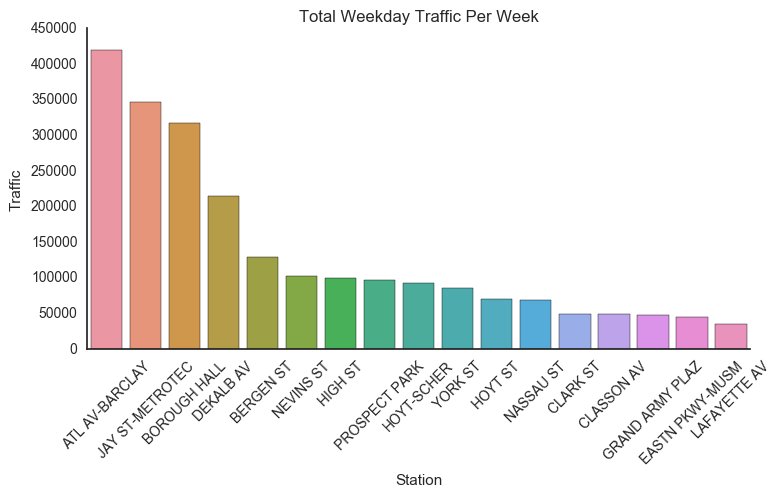

In [157]:
weekdays = sns.factorplot('station', 'weekly_traffic', data = total_by_station, kind = 'bar', aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Station')
plt.ylabel('Traffic')
plt.title("Total Weekday Traffic Per Week")

weekdays.savefig('weekday_totals.png')

In [139]:
top_stations_lst = ['ATL AV-BARCLAY',
                   'JAY ST-METROTEC',
                   'BOROUGH HALL',
                   'DEKALB AV']

top_stations = potential_stations[potential_stations['station'].isin(top_stations_lst)]
top_stations = top_stations.groupby(by=['station', 'parsed_time'], as_index=False).sum()[['station', 'parsed_time','traffic']]
top_stations.set_index('parsed_time', drop=True, inplace=True)
top_stations = top_stations.groupby(by=['station']).resample('4H')
top_stations = top_stations.reset_index()

/Users/evaward/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


In [140]:
top_stations.loc[top_stations['parsed_time'] == '2017-01-22 00:00:00', 'label'] = '8pm-12am'
top_stations.loc[top_stations['parsed_time'] == '2017-01-22 04:00:00', 'label'] = '12am-4am'
top_stations.loc[top_stations['parsed_time'] == '2017-01-22 08:00:00', 'label'] = '4am-8am'
top_stations.loc[top_stations['parsed_time'] == '2017-01-22 12:00:00', 'label'] = '8am-12pm'
top_stations.loc[top_stations['parsed_time'] == '2017-01-22 16:00:00', 'label'] = '12pm-4pm'
top_stations.loc[top_stations['parsed_time'] == '2017-01-22 20:00:00', 'label'] = '4pm-8pm'

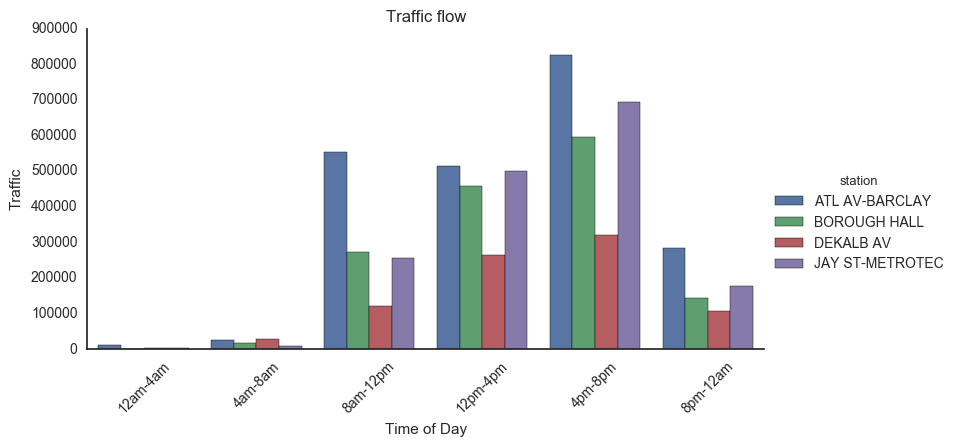

In [160]:
order = ['12am-4am', '4am-8am', '8am-12pm', '12pm-4pm', '4pm-8pm', '8pm-12am']

flow_bar = sns.factorplot('label', 'traffic', hue ='station', kind = 'bar', data = top_stations, aspect = 2, x_order=order)
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Traffic')
plt.title("Traffic flow")

flow_bar.savefig('traffic_flow_bar.png')

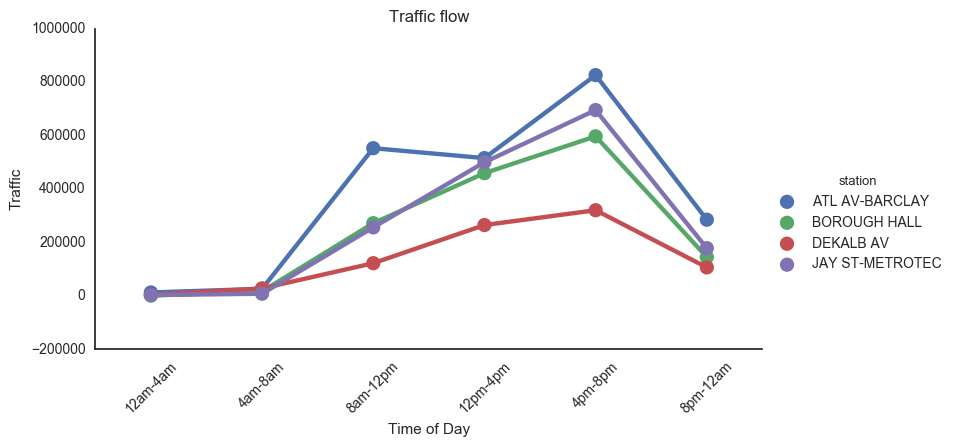

In [161]:
order = ['12am-4am', '4am-8am', '8am-12pm', '12pm-4pm', '4pm-8pm', '8pm-12am']

flow_line = sns.factorplot('label', 'traffic', hue ='station', data = top_stations, aspect = 2, x_order=order)
flow_line
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Traffic')
plt.title("Traffic flow")

flow_line.savefig('traffic_flow_line.png')

In [162]:
stations_by_weekday = potential_stations[potential_stations['station'].isin(top_stations_lst)]
stations_by_weekday = stations_by_weekday.groupby(by=['station', 'weekday'], as_index=False).sum()[['station', 'weekday','traffic']]
stations_by_weekday

,station,weekday,traffic
0,ATL AV-BARCLAY,0,454322.0
1,ATL AV-BARCLAY,1,501618.0
2,ATL AV-BARCLAY,2,512003.0
3,ATL AV-BARCLAY,3,515795.0
4,ATL AV-BARCLAY,4,535801.0
5,BOROUGH HALL,0,330511.0
6,BOROUGH HALL,1,394592.0
7,BOROUGH HALL,2,404131.0
8,BOROUGH HALL,3,403403.0
9,BOROUGH HALL,4,373241.0


In [165]:
stations_by_weekday.loc[stations_by_weekday['weekday'] == 0, 'label'] = 'Monday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 1, 'label'] = 'Tuesday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 2, 'label'] = 'Wednesday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 3, 'label'] = 'Thursday'
stations_by_weekday.loc[stations_by_weekday['weekday'] == 4, 'label'] = 'Friday'

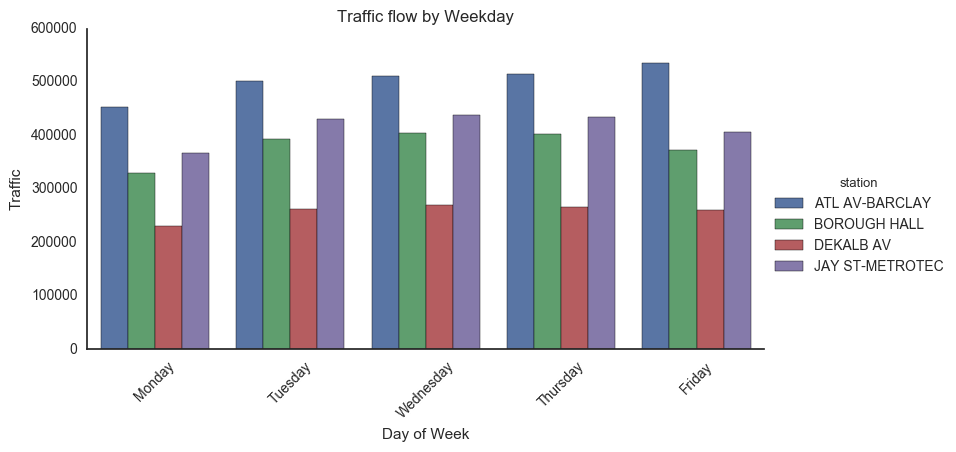

In [167]:
weekday_bar = sns.factorplot('label', 'traffic', hue ='station', kind = 'bar', data = stations_by_weekday, aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.title("Traffic flow by Weekday")

weekday_bar.savefig('weekday_bar.png');